# Metapaths for Link Prediction

## Introduction

The generalization of a bipartite network is a multipartite network, with an arbitrary number of node classes. In order to take full advantage of all the information in such a network, we need a new topological feature that moves beyond common neighbors and local community links, because these features only depend on the first degree neighbors of each node. One possible candidate for such a feature is the metapath, as used in (Shakibian et al, Scientific Reports 2017). A metapath describes one specific way of moving from a node of one type to another node (of the same or different type). It is defined by the sequence of node types that the path must follow - for instance the sequence source neuron -> neurotransmitter -> neuroreceptor -> neurotransmitter is one example of a metapath. We can then have a metapath instance, which is a particular sequence of connected nodes that follows the schema laid out by a given metapath. To continue the example, an instance of the previously defined metapath might be ADAL -> Glu -> some neuroreceptor -> some other neurotransmitter, but clearly there can be many instances of a given metapath. In this notebook we have attempted to generalize the bipartite framework for mutual information link prediction to the multipartite case, using metapaths as the main feature.

## Setup

Autoreload and some code copied from the Keras machine learning documentation to keep tensorflow results reproducible, plus all the other libraries required.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

# Rest of code follows ...

Using TensorFlow backend.


In [3]:
import matplotlib.pyplot as plt
import pickle

from sklearn.metrics import precision_recall_curve, auc
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer
import scipy.stats

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l1, l1_l2
from keras.initializers import he_normal
from keras.activations import sigmoid

import b_val as val

## Metapath Probability Definition

In order to generalize the mutual information method to multipartite networks, we need a definition of the probability of a link existing given that a certain metapath instance connects the two nodes in question. As a natural extension of the monopartite clustering coefficient (triangles) and the bipartite LCL clustering coefficient (quadrangles), let us define this probability as a sort of 'metapath clustering coefficient'.

$$ p(L_{xy}|p_z) = \frac{N_{\text{closed}}}{N_{\text{open}}+N_{\text{closed}}} $$

where $N_{\text{closed}}$ and $N_{\text{open}}$ can be described as follows. Consider the path $p_z$: $x$ -> $n_1$ -> ... -> $n_k$ -> $y$ with $k$ intermediate nodes between $x$ and $y$. The node closest to $x$ is $n_1$ and the node closest to $y$ is $n_k$. We look at all the metapaths that start at a node with the same type as $x$ (call it $x'$), follow $p_z$ from $n_1$ through $n_k$, and end at a node of the same type as $y$ (call it $y'$). In a sense these are the most similar paths to $p_z$ without actually replicating $p_z$. Then $N_{closed}$ is the number of such paths where $x'$ and $y'$ are connected, and $N_{\text{open}}$ is the number of such paths where they are not. 

It turns out that this definition is all that is required to use the mutual information method for link prediction in the multipartite case, since the 'a priori' probability $p(L_{xy})$ still depends only on the degrees of $x$ and $y$ within their particular bipartite section of the larger multipartite network. The difference is that now instead of only common neighbors and LCLs to use as features, we can use any metapath that connects $x$ and $y$. Interestingly, both common neighbors and LCLs are special cases of metapaths, for example the path for an LCL in a bipartite network is $x$ -> (node of same type as $y$) -> (node of same type as $x$) -> $y$.


## Precomputed Metapath Scores

In order to count the number of open and closed metapaths in a multipartite network, we implemented a recursive depth-first search algorithm that runs through all paths and quickly eliminates those that do not fit the target criteria. The code for this implementation is in the metapaths.py library. The algorithm runs fairly quickly for short metapaths, but slows down significantly for longer paths. Therefore we precomputed and saved the self information scores on the Elegans dataset using all the metapaths with lengths up to 6 and saved them to a file. The paths are (in no particular order):

source -> NT -> source -> NT 

source -> NT -> NR -> NT

source -> NT -> source -> NT -> source -> NT

source -> NT -> NR -> NT -> source -> NT

source -> NT -> NR -> NT -> NR -> NT

source -> NT -> source -> NT -> NR -> NT

source -> NT -> NR -> target -> NR -> NT

In the saved data, 10 cross validation trials were executed and the results were concatenated into one large array with shape $((\text{# of missing links})*10, 7)$. The ground truth connections are stored in an array with shape $((\text{# of missing links})*10, 7)$.

Now that all the score from these paths are computed, we can try combining them using either a linear combination or some machine learning. 

In [4]:
# Load scores
with open('mp_X.pkl', 'rb') as inf:
    X = pickle.load(inf)

In [5]:
# Load ground truth
with open('mp_Y.pkl', 'rb') as inf:
    y = pickle.load(inf)

## Machine Learning

In order to avoid the 'black box' aspect of machine learning, we have gone with the simplest neural network we could think of. Essentially it implements the transformation

$$ \text{score} = \sigma(W_2\cdot (W_1\cdot X) + b) $$

where the input $X$ is the vector of seven diferent metapath scores, $W_1$ is a vector of seven wieghts, $W_2$ is a single weight for the classification layer, and $b$ is a trainable bias parameter. All the data is used for training since really we are only interested in seeing whether there is some optimal combination of the metapath scores that is better than the bipartite LCL metapath. 

In [6]:
# Machine learning model
model = Sequential()
model.add(Dense(1, input_dim=7, activation='linear', kernel_initializer='ones', use_bias=False))
#model.add(Dropout(0.2)) like example in notebook ml_local_community
model.add(Dense(1, activation='sigmoid'))
#model.add(Dropout(0.2))  like example in notebook ml_local_community

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.fit(np.copy(X), np.copy(y),
          epochs=20,
          batch_size=128)

Epoch 1/20
87400/87400 [==============================] - 1s 10us/step - loss: 1.7783 - acc: 0.8269
Epoch 2/20
87400/87400 [==============================] - 1s 9us/step - loss: 0.1906 - acc: 0.9906
Epoch 3/20
87400/87400 [==============================] - 1s 10us/step - loss: 0.1593 - acc: 0.9828
Epoch 4/20
87400/87400 [==============================] - 1s 10us/step - loss: 0.1222 - acc: 0.9921
Epoch 5/20
87400/87400 [==============================] - 1s 9us/step - loss: 0.1015 - acc: 0.9921
Epoch 6/20
87400/87400 [==============================] - 1s 10us/step - loss: 0.0820 - acc: 0.9921
Epoch 7/20
87400/87400 [==============================] - 1s 10us/step - loss: 0.0675 - acc: 0.9921
Epoch 8/20
87400/87400 [==============================] - 1s 9us/step - loss: 0.0591 - acc: 0.9921
Epoch 9/20
87400/87400 [==============================] - 1s 10us/step - loss: 0.0533 - acc: 0.9921
Epoch 10/20
87400/87400 [==============================] - 1s 10us/step - loss: 0.0494 - acc: 0.9921
Ep

In [7]:
# Use trained model to generate scores
pred = model.predict(np.copy(X))

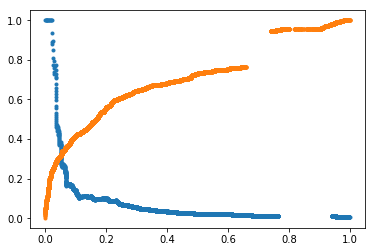

(0.08059372645622737, 0.7142696377563726)

In [8]:
# Compare to results from the LCL metapath - not great
val.evaluate_predictions(np.copy(y), pred, plot=True)

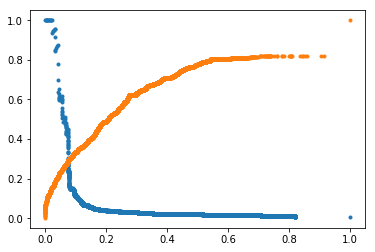

(0.08131365880885413, 0.6755037029979993)

In [9]:
val.evaluate_predictions(np.copy(y), np.copy(X)[:,0], plot=True)

## A Simpler Case

It turns out that if we combine the scores from only the first two metapaths (going by the list earlier in the notebook), we do get a better results. This suggests that there may be an effective way of combining more of the metapaths, although we have not had the time to look into this problem in enough detail. We think it would be worth investigating further. 

In [10]:
scores_1_2 = []
weights_1_2 = np.linspace(-10, 10, 100)
for w in weights_1_2:
    scores_1_2.append(val.evaluate_predictions(y, X[:,0] + w*X[:,1])[0])

Text(0,0.5,'AUPR score')

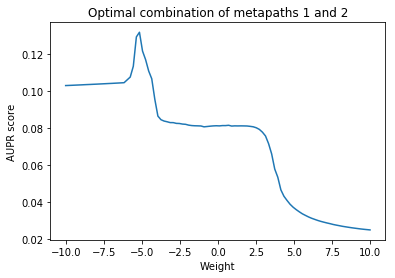

In [11]:
plt.plot(weights_1_2, scores_1_2)
plt.title('Optimal combination of metapaths 1 and 2')
plt.xlabel('Weight')
plt.ylabel('AUPR score')

In [12]:
idx = np.argmax(scores_1_2)
print('Best weight:', weights_1_2[idx])
print('Best AUPR score:', scores_1_2[idx])

Best weight: -5.151515151515151
Best AUPR score: 0.13197051438635787
